# Deep Learning: A Visual Approach

---

Andrew Glassner, https://glassner.com

Order: https://nostarch.com/deep-learning-visual-approach

GitHub: https://github.com/blueberrymusic

---

### What's in this notebook

This notebook is provided as a “behind-the-scenes” look at code used to make some of the figures in this chapter. It is cleaned up a bit from the original code that I hacked together, and is only lightly commented. I wrote the code to be easy to interpret and understand, even for those who are new to Python. I tried never to be clever or even more efficient at the cost of being harder to understand. The code is in Python3, using the versions of libraries as of April 2021.

This notebook may contain additional code to create models and images not in the book. That material is included here to demonstrate additional techniques.

Note that I've included the output cells in this saved notebook, but Jupyter doesn't save the variables or data that were used to generate them. To recreate any cell's output, evaluate all the cells from the start up to that cell. A convenient way to experiment is to first choose 'Restart & Run All' from the Kernel menu, so that everything's been defined and is up to date. Then you can experiment using the variables, data, functions, and other stuff defined in this notebook.

### A note on variation of output

Note as always that due to the use of random numbers, some of the results here may differ from those in the book (since I re-ran everything to prepare this notebook), and will probably be different yet again if you run this notebook.

---

Adapted for **IST 691 Deep Learning in Practice**, iSchool, Syracuse University

## Chapter 18: Autoencoders - Notebook 2: MNIST 1

In [ ]:
# Some code inspired or based on:
#    https://blog.keras.io/building-autoencoders-in-keras.html
#    https://jmetzen.github.io/2015-11-27/vae.html
#    https://arxiv.org/pdf/1606.05908.pdf  (https://github.com/cdoersch/vae_tutorial)

In [1]:
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense
import numpy as np
import h5py
from pathlib import Path
import matplotlib.pyplot as plt

from keras import backend as keras_backend
keras_backend.set_image_data_format('channels_last')

2024-06-05 21:09:55.201185: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/zanealderfer/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/zanealderfer/opt/anaconda3/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/Users/zanealderfer/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or 

In [2]:
random_seed = 42
np.random.seed(random_seed)

# Read MNIST data. We won't be using the y_train or y_test data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
pixels_per_image = np.prod(X_train.shape[1:])

# Cast values into the current floating-point type
X_train = keras_backend.cast_to_floatx(X_train)
X_test = keras_backend.cast_to_floatx(X_test)

# Normalize the range from [0,255] to [0,1]
X_train /= 255.
X_test /= 255.

# Reshape the data into a grid with one row per sample, each row 784 (28*28) pixels
X_train = X_train.reshape((len(X_train), pixels_per_image))
X_test = X_test.reshape((len(X_test), pixels_per_image))

print('X_train.shape = ', X_train.shape, ' X_test.shape = ', X_test.shape)

X_train.shape =  (60000, 784)  X_test.shape =  (10000, 784)


In [3]:
# show a grid of MNIST images and our prediction for each one

def draw_predictions_set(predictions, filename = None):
    plt.figure(figsize = (8, 4))
    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.imshow(X_test[i].reshape(28, 28), vmin = 0, vmax = 1, cmap = 'gray')
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.subplot(2, 5, i + 6)
        plt.imshow(predictions[i].reshape(28, 28), vmin = 0, vmax = 1, cmap = 'gray')
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

In [4]:
X_train.shape

(60000, 784)

In [5]:
# Build and train our first autoencoder
num_latent_vars = 20

AE1 = Sequential()
AE1.add(Dense(num_latent_vars, input_dim = pixels_per_image, activation = 'relu'))
AE1.add(Dense(pixels_per_image, activation = 'sigmoid'))
AE1.compile(optimizer = 'adam', loss = 'binary_crossentropy')
np.random.seed(42)

AE1.fit(X_train, X_train,
               epochs = 50, batch_size = 128, shuffle = True,
               verbose = 2,
               validation_data = (X_test, X_test))

Epoch 1/50
469/469 - 6s - loss: 0.2475 - val_loss: 0.1779 - 6s/epoch - 14ms/step
Epoch 2/50
469/469 - 5s - loss: 0.1611 - val_loss: 0.1462 - 5s/epoch - 11ms/step
Epoch 3/50
469/469 - 5s - loss: 0.1405 - val_loss: 0.1335 - 5s/epoch - 11ms/step
Epoch 4/50
469/469 - 5s - loss: 0.1310 - val_loss: 0.1264 - 5s/epoch - 10ms/step
Epoch 5/50
469/469 - 4s - loss: 0.1255 - val_loss: 0.1220 - 4s/epoch - 9ms/step
Epoch 6/50
469/469 - 6s - loss: 0.1219 - val_loss: 0.1193 - 6s/epoch - 12ms/step
Epoch 7/50
469/469 - 5s - loss: 0.1196 - val_loss: 0.1171 - 5s/epoch - 11ms/step
Epoch 8/50
469/469 - 5s - loss: 0.1183 - val_loss: 0.1163 - 5s/epoch - 11ms/step
Epoch 9/50
469/469 - 5s - loss: 0.1176 - val_loss: 0.1157 - 5s/epoch - 10ms/step
Epoch 10/50
469/469 - 5s - loss: 0.1172 - val_loss: 0.1154 - 5s/epoch - 10ms/step
Epoch 11/50
469/469 - 5s - loss: 0.1169 - val_loss: 0.1152 - 5s/epoch - 11ms/step
Epoch 12/50
469/469 - 5s - loss: 0.1167 - val_loss: 0.1149 - 5s/epoch - 12ms/step
Epoch 13/50
469/469 - 4s -

313/313 [==============================] - 1s 2ms/step


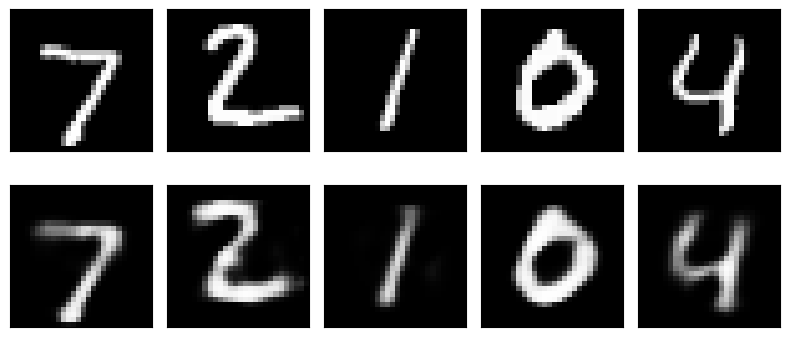

In [6]:
predictions1 = AE1.predict(X_test)
draw_predictions_set(predictions1, 'NB2-MLP-AE1')

In [7]:
# Build and train our second, more compress-y autoencoder
num_latent_vars = 10

AE2 = Sequential()
AE2.add(Dense(num_latent_vars, input_dim = pixels_per_image, activation = 'relu'))
AE2.add(Dense(pixels_per_image, activation = 'sigmoid'))
AE2.compile(optimizer = 'adam', loss = 'binary_crossentropy')

np.random.seed(42)
AE2.fit(X_train, X_train,
               epochs = 50, batch_size = 128, shuffle = True,
               verbose = 2,
               validation_data=(X_test, X_test))

Epoch 1/50
469/469 - 2s - loss: 0.2788 - val_loss: 0.2027 - 2s/epoch - 5ms/step
Epoch 2/50
469/469 - 1s - loss: 0.1859 - val_loss: 0.1742 - 1s/epoch - 3ms/step
Epoch 3/50
469/469 - 1s - loss: 0.1711 - val_loss: 0.1664 - 1s/epoch - 3ms/step
Epoch 4/50
469/469 - 2s - loss: 0.1661 - val_loss: 0.1632 - 2s/epoch - 5ms/step
Epoch 5/50
469/469 - 1s - loss: 0.1634 - val_loss: 0.1609 - 1s/epoch - 3ms/step
Epoch 6/50
469/469 - 1s - loss: 0.1613 - val_loss: 0.1591 - 1s/epoch - 3ms/step
Epoch 7/50
469/469 - 1s - loss: 0.1597 - val_loss: 0.1578 - 1s/epoch - 3ms/step
Epoch 8/50
469/469 - 1s - loss: 0.1585 - val_loss: 0.1566 - 1s/epoch - 3ms/step
Epoch 9/50
469/469 - 1s - loss: 0.1575 - val_loss: 0.1557 - 1s/epoch - 3ms/step
Epoch 10/50
469/469 - 1s - loss: 0.1568 - val_loss: 0.1551 - 1s/epoch - 3ms/step
Epoch 11/50
469/469 - 1s - loss: 0.1563 - val_loss: 0.1548 - 1s/epoch - 3ms/step
Epoch 12/50
469/469 - 2s - loss: 0.1559 - val_loss: 0.1542 - 2s/epoch - 4ms/step
Epoch 13/50
469/469 - 2s - loss: 0.15

313/313 [==============================] - 1s 2ms/step


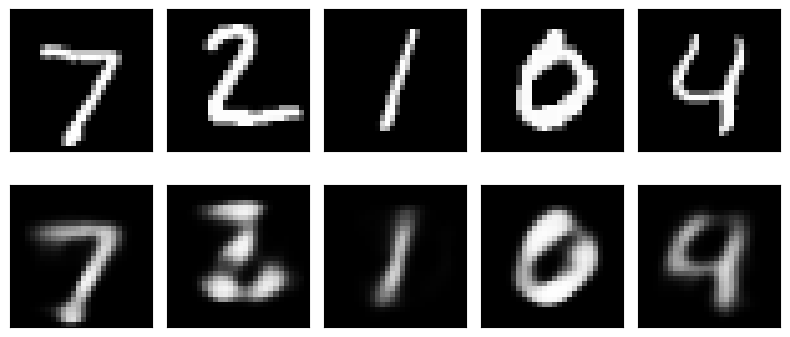

In [8]:
predictions2 = AE2.predict(X_test)
draw_predictions_set(predictions2, 'NB2-MLP-AE2')

In [9]:
# Build and train our third, super compress-y autoencoder
num_latent_vars = 3

AE3 = Sequential()
AE3.add(Dense(num_latent_vars, input_dim = pixels_per_image, activation='relu'))
AE3.add(Dense(pixels_per_image, activation='sigmoid'))
AE3.compile(optimizer = 'adam', loss = 'binary_crossentropy')

AE3.fit(X_train, X_train,
               epochs = 50, batch_size = 128, shuffle = True,
               verbose = 2,
               validation_data=(X_test, X_test))

Epoch 1/50
469/469 - 3s - loss: 0.3223 - val_loss: 0.2561 - 3s/epoch - 7ms/step
Epoch 2/50
469/469 - 1s - loss: 0.2415 - val_loss: 0.2324 - 1s/epoch - 3ms/step
Epoch 3/50
469/469 - 1s - loss: 0.2308 - val_loss: 0.2273 - 1s/epoch - 3ms/step
Epoch 4/50
469/469 - 1s - loss: 0.2271 - val_loss: 0.2245 - 1s/epoch - 3ms/step
Epoch 5/50
469/469 - 1s - loss: 0.2248 - val_loss: 0.2225 - 1s/epoch - 3ms/step
Epoch 6/50
469/469 - 1s - loss: 0.2231 - val_loss: 0.2210 - 1s/epoch - 3ms/step
Epoch 7/50
469/469 - 1s - loss: 0.2218 - val_loss: 0.2201 - 1s/epoch - 3ms/step
Epoch 8/50
469/469 - 2s - loss: 0.2208 - val_loss: 0.2191 - 2s/epoch - 4ms/step
Epoch 9/50
469/469 - 2s - loss: 0.2199 - val_loss: 0.2184 - 2s/epoch - 4ms/step
Epoch 10/50
469/469 - 1s - loss: 0.2192 - val_loss: 0.2178 - 1s/epoch - 3ms/step
Epoch 11/50
469/469 - 1s - loss: 0.2186 - val_loss: 0.2173 - 1s/epoch - 3ms/step
Epoch 12/50
469/469 - 1s - loss: 0.2180 - val_loss: 0.2166 - 1s/epoch - 3ms/step
Epoch 13/50
469/469 - 1s - loss: 0.21

313/313 [==============================] - 1s 2ms/step


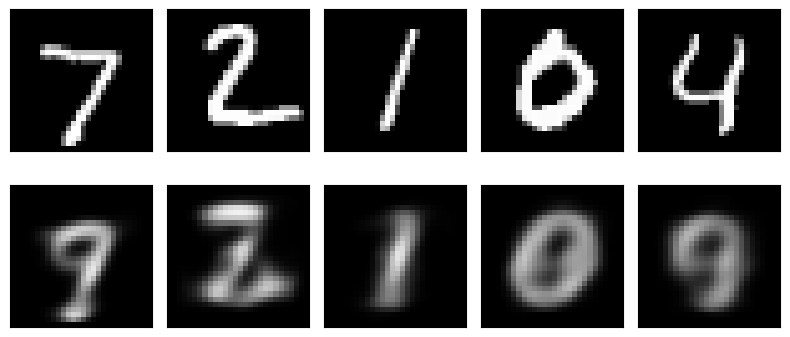

In [10]:
predictions3 = AE3.predict(X_test)
draw_predictions_set(predictions3, 'NB2-MLP-AE3')

# Activity 1
Create a deeper autoencoder

In [ ]:
num_latent_vars = 10

AE4 = Sequential()
# Define the rest of the layers
AE4.add(Dense(pixels_per_image, activation = 'sigmoid'))
AE4.compile(optimizer = 'adam', loss = 'binary_crossentropy')

np.random.seed(42)
AE4.fit(X_train, X_train,
               epochs = 50, batch_size = 128, shuffle = True,
               verbose = 2,
               validation_data = (X_test, X_test))

In [ ]:
predictions4 = AE4.predict(X_test)
draw_predictions_set(predictions4, 'NB2-MLP-AE4')

In [13]:
# rebuild AE4 with the Functional API so we can play with the decoder alone
from keras.layers import Input

num_latent_vars = 20

AE5_encoder_input = Input(shape = (784,))
AE5_encoder_512 = Dense(512, activation = 'relu')
AE5_encoder_256 = Dense(256, activation = 'relu')
AE5_encoder_latent = Dense(num_latent_vars, activation = 'relu')

AE5_decoder_256 = Dense(256, activation = 'relu')
AE5_decoder_512 = Dense(512, activation = 'relu')
AE5_decoder_out = Dense(784, activation = 'sigmoid')

AE5_encoder_step_1 = AE5_encoder_512(AE5_encoder_input)
AE5_encoder_step_2 = AE5_encoder_256(AE5_encoder_step_1)
AE5_encoder_output = AE5_encoder_latent(AE5_encoder_step_2)

AE5_decoder_step_1 = AE5_decoder_256(AE5_encoder_output)
AE5_decoder_step_2 = AE5_decoder_512(AE5_decoder_step_1)
AE5_decoder_output = AE5_decoder_out(AE5_decoder_step_2)

AE5 = Model(AE5_encoder_input, AE5_decoder_output)

AE5_encoder_only_model = Model(AE5_encoder_input, AE5_encoder_output)

AE5_decoder_only_input = Input(shape=(num_latent_vars,))
AE5_decoder_only_step_1 = AE5_decoder_256(AE5_decoder_only_input)
AE5_decoder_only_step_2 = AE5_decoder_512(AE5_decoder_only_step_1)
AE5_decoder_only_output = AE5_decoder_out(AE5_decoder_only_step_2)
AE5_decoder_only_model = Model(AE5_decoder_only_input, AE5_decoder_only_output)

In [14]:
AE5.compile(optimizer = 'adam', loss = 'binary_crossentropy')

np.random.seed(42)
AE5.fit(X_train, X_train,
               epochs = 50, batch_size = 128, shuffle = True,
               verbose = 2,
               validation_data = (X_test, X_test))

Epoch 1/50
469/469 - 5s - loss: 0.1718 - val_loss: 0.1180 - 5s/epoch - 12ms/step
Epoch 2/50
469/469 - 2s - loss: 0.1104 - val_loss: 0.1032 - 2s/epoch - 4ms/step
Epoch 3/50
469/469 - 2s - loss: 0.1018 - val_loss: 0.0984 - 2s/epoch - 4ms/step
Epoch 4/50
469/469 - 2s - loss: 0.0976 - val_loss: 0.0958 - 2s/epoch - 4ms/step
Epoch 5/50
469/469 - 2s - loss: 0.0951 - val_loss: 0.0938 - 2s/epoch - 4ms/step
Epoch 6/50
469/469 - 2s - loss: 0.0934 - val_loss: 0.0925 - 2s/epoch - 4ms/step
Epoch 7/50
469/469 - 3s - loss: 0.0919 - val_loss: 0.0914 - 3s/epoch - 5ms/step
Epoch 8/50
469/469 - 2s - loss: 0.0908 - val_loss: 0.0903 - 2s/epoch - 4ms/step
Epoch 9/50
469/469 - 2s - loss: 0.0898 - val_loss: 0.0896 - 2s/epoch - 4ms/step
Epoch 10/50
469/469 - 2s - loss: 0.0891 - val_loss: 0.0892 - 2s/epoch - 4ms/step
Epoch 11/50
469/469 - 2s - loss: 0.0884 - val_loss: 0.0884 - 2s/epoch - 4ms/step
Epoch 12/50
469/469 - 2s - loss: 0.0878 - val_loss: 0.0882 - 2s/epoch - 4ms/step
Epoch 13/50
469/469 - 2s - loss: 0.0

1/1 [==============================] - 0s 20ms/step


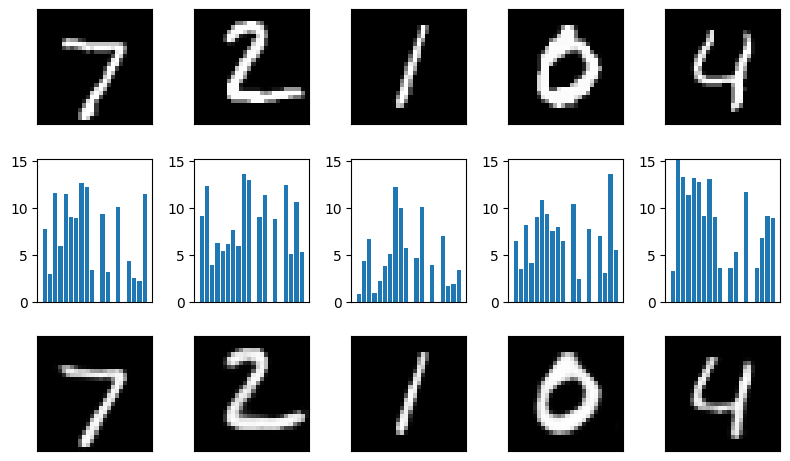

In [15]:
# show the input data, its latent values, and the corresponding predicted images
np.random.seed(random_seed)
encoder_predictions = AE5_encoder_only_model.predict(X_test)

plt.figure(figsize = (8, 5))
latent_min = np.min(encoder_predictions[0:5])
latent_max = np.max(encoder_predictions[0:5])
for i in range(5):
    plt.subplot(3, 5, i + 1)
    plt.imshow(X_test[i].reshape(28, 28), vmin = 0, vmax = 1, cmap = 'gray')
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    plt.subplot(3, 5, i + 6)
    plt.bar(np.arange(len(encoder_predictions[i])), encoder_predictions[i])
    plt.xticks([], [])
    plt.ylim(latent_min, latent_max)

    plt.subplot(3, 5, i + 11)
    decoder_model_input = np.resize(encoder_predictions[i], (1, len(encoder_predictions[i])))
    decoder_prediction = AE5_decoder_only_model.predict(decoder_model_input)
    plt.imshow(decoder_prediction.reshape(28, 28), vmin = 0, vmax = 1, cmap = 'gray')
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

In [17]:
# show the latent values and the corresponding predicted images
def show_latents_and_predictions(predictions, filename = None):
    plt.figure(figsize = (8, 4))
    latent_min = np.min(predictions[0:5])
    latent_max = np.max(predictions[0:5])
    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.bar(np.arange(len(predictions[i])), predictions[i])
        plt.xticks([], [])
        plt.ylim(latent_min, latent_max)

        plt.subplot(2, 5, i + 6)
        decoder_model_input = np.resize(predictions[i], (1, len(predictions[i])))
        decoder_prediction = AE5_decoder_only_model.predict(decoder_model_input)
        plt.imshow(decoder_prediction.reshape(28, 28), vmin = 0, vmax = 1, cmap = 'gray')
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

1/1 [==============================] - 0s 19ms/step


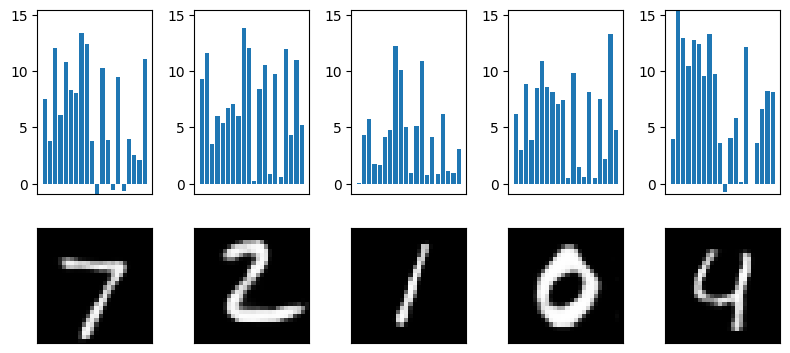

In [19]:
# add [-1,1] noise to all values
encoder_predictions = np.array(AE5_encoder_only_model.predict(X_test))
np.random.seed(random_seed)
noise = 1
for i in range(encoder_predictions.shape[0]):
    for j in range(len(encoder_predictions[i])):
        encoder_predictions[i][j] += np.random.uniform(low=-noise, high=noise)
show_latents_and_predictions(encoder_predictions, 'NB2-MLP-AE5-prediction-latent-values-with-noise-1')

# Activity #2
Add -10 to +10 noise to all variables

In [ ]:
data = {
    'A': [10, 20, 30, 40, 50],
    'B': [5, 15, 25, 35, 45],
    'C': [2, 4, 6, 8, 10]
}

df = pd.DataFrame(data)

# Set the noise range
noise_min = -10
noise_max = 10

# Generate noise
noise = np.random.uniform(noise_min, noise_max, df.shape)

# Add noise to the DataFrame
df_noisy = df + noise

In [21]:
# make a functional model with 2 latent variables for the scatter plot
from keras.layers import Input

num_latent_vars = 2

AE6_encoder_input = Input(shape=(784,))
AE6_encoder_512 = Dense(512, activation = 'relu')
AE6_encoder_256 = Dense(256, activation = 'relu')
AE6_encoder_latent = Dense(num_latent_vars, activation = 'relu')

AE6_decoder_256 = Dense(256, activation = 'relu')
AE6_decoder_512 = Dense(512, activation = 'relu')
AE6_decoder_out = Dense(784, activation = 'sigmoid')

AE6_encoder_step_1 = AE6_encoder_512(AE6_encoder_input)
AE6_encoder_step_2 = AE6_encoder_256(AE6_encoder_step_1)
AE6_encoder_output = AE6_encoder_latent(AE6_encoder_step_2)

AE6_decoder_step_1 = AE6_decoder_256(AE6_encoder_output)
AE6_decoder_step_2 = AE6_decoder_512(AE6_decoder_step_1)
AE6_decoder_output = AE6_decoder_out(AE6_decoder_step_2)

AE6 = Model(AE6_encoder_input, AE6_decoder_output)

AE6_encoder_only_model = Model(AE6_encoder_input, AE6_encoder_output)

AE6_decoder_only_input = Input(shape=(num_latent_vars,))
AE6_decoder_only_step_1 = AE6_decoder_256(AE6_decoder_only_input)
AE6_decoder_only_step_2 = AE6_decoder_512(AE6_decoder_only_step_1)
AE6_decoder_only_output = AE6_decoder_out(AE6_decoder_only_step_2)
AE6_decoder_only_model = Model(AE6_decoder_only_input, AE6_decoder_only_output)

AE6.compile(optimizer = 'adam', loss = 'binary_crossentropy')

np.random.seed(42)
AE6.fit(X_train, X_train,
               epochs = 50, batch_size = 128, shuffle = True,
               verbose = 2,
               validation_data=(X_test, X_test))

Epoch 1/50
469/469 - 4s - loss: 0.2347 - val_loss: 0.2084 - 4s/epoch - 9ms/step
Epoch 2/50
469/469 - 2s - loss: 0.2006 - val_loss: 0.1941 - 2s/epoch - 4ms/step
Epoch 3/50
469/469 - 2s - loss: 0.1910 - val_loss: 0.1885 - 2s/epoch - 5ms/step
Epoch 4/50
469/469 - 2s - loss: 0.1870 - val_loss: 0.1851 - 2s/epoch - 4ms/step
Epoch 5/50
469/469 - 2s - loss: 0.1842 - val_loss: 0.1835 - 2s/epoch - 4ms/step
Epoch 6/50
469/469 - 2s - loss: 0.1823 - val_loss: 0.1811 - 2s/epoch - 4ms/step
Epoch 7/50
469/469 - 3s - loss: 0.1807 - val_loss: 0.1802 - 3s/epoch - 6ms/step
Epoch 8/50
469/469 - 3s - loss: 0.1792 - val_loss: 0.1796 - 3s/epoch - 5ms/step
Epoch 9/50
469/469 - 2s - loss: 0.1780 - val_loss: 0.1778 - 2s/epoch - 5ms/step
Epoch 10/50
469/469 - 2s - loss: 0.1767 - val_loss: 0.1770 - 2s/epoch - 4ms/step
Epoch 11/50
469/469 - 2s - loss: 0.1759 - val_loss: 0.1766 - 2s/epoch - 4ms/step
Epoch 12/50
469/469 - 2s - loss: 0.1750 - val_loss: 0.1756 - 2s/epoch - 4ms/step
Epoch 13/50
469/469 - 2s - loss: 0.17

In [22]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt

# scatter plot from AE6
def draw_scatter(diameter, limits=None, filename=None):
    encoder_predictions = np.array(AE6_encoder_only_model.predict(X_test))
    np.random.seed(random_seed)

    plt.clf()
    fig = plt.figure(figsize=(10, 10))

    ax = fig.add_subplot(111, aspect = 'equal')

    # display a 2D plot of the digit classes in the latent space
    clrs = [ 'red', 'sandybrown', 'sienna', 'gold', 'palegreen',
            'limegreen', 'deepskyblue', 'blue', 'plum', 'magenta' ]

    for i in range(len(encoder_predictions)):
        p = patches.Circle(encoder_predictions[i], diameter,
                            edgecolor = 'black', facecolor = clrs[y_test[i]])
        ax.add_patch(p)

    handle_list = []
    for i in range(10):
        p = patches.Patch(color = clrs[i], label = str(i))
        handle_list.append(p)
    ax.legend(handles=handle_list, loc = 'upper right', shadow = True)

    if limits:
        (pxmin, pxmax, pymin, pymax) = limits
    else:
        xmin = np.min(encoder_predictions[:,0])
        xmax = np.max(encoder_predictions[:,0])
        pxmin = xmin - (.05 * (xmax-xmin))
        pxmax = xmax + (.15 * (xmax-xmin))
        ymin = np.min(encoder_predictions[:,1])
        ymax = np.max(encoder_predictions[:,1])
        pymin = ymin - (.05 * (ymax-ymin))
        pymax = ymax + (.05 * (ymax-ymin))
    ax.set_ylim([pymin, pymax])
    ax.set_xlim([pxmin, pxmax])

    plt.show()

313/313 [==============================] - 0s 1ms/step


<Figure size 640x480 with 0 Axes>

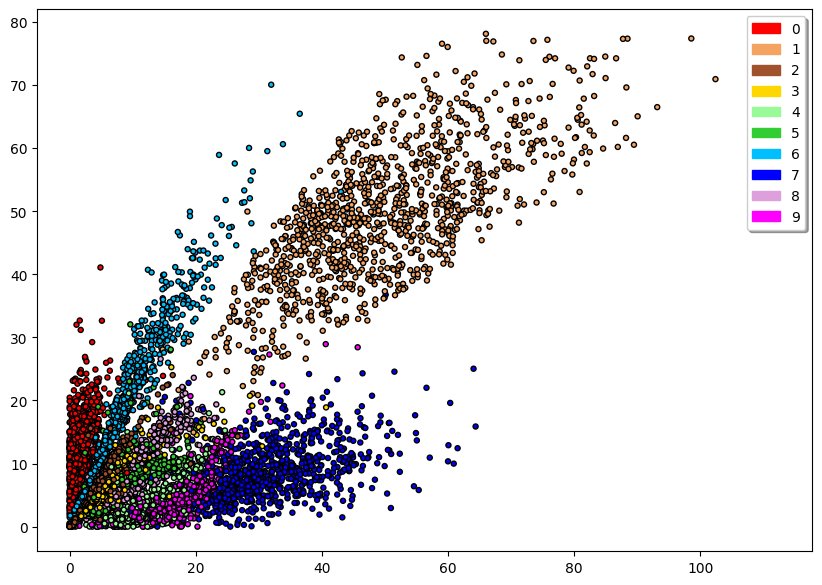

In [23]:
draw_scatter(.4,
             limits = None,
             filename = 'NB2-MLP-AE6-latent-scatter')

In [24]:
def draw_decoder_grid(steps = 17, limits = None, filename = None):

    # display a 2D manifold of the digits
    digit_size = 28
    figure = np.zeros((digit_size * steps, digit_size * steps))
    grid_x = np.linspace(limits[1], limits[0], steps)
    grid_y = np.linspace(limits[2], limits[3], steps)

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):

            latents = np.array([[xi, yi]])
            decoder_prediction = AE6_decoder_only_model.predict(latents)

            digit = decoder_prediction[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(figure, cmap='gray')
    plt.show()

1/1 [==============================] - 0s 22ms/step


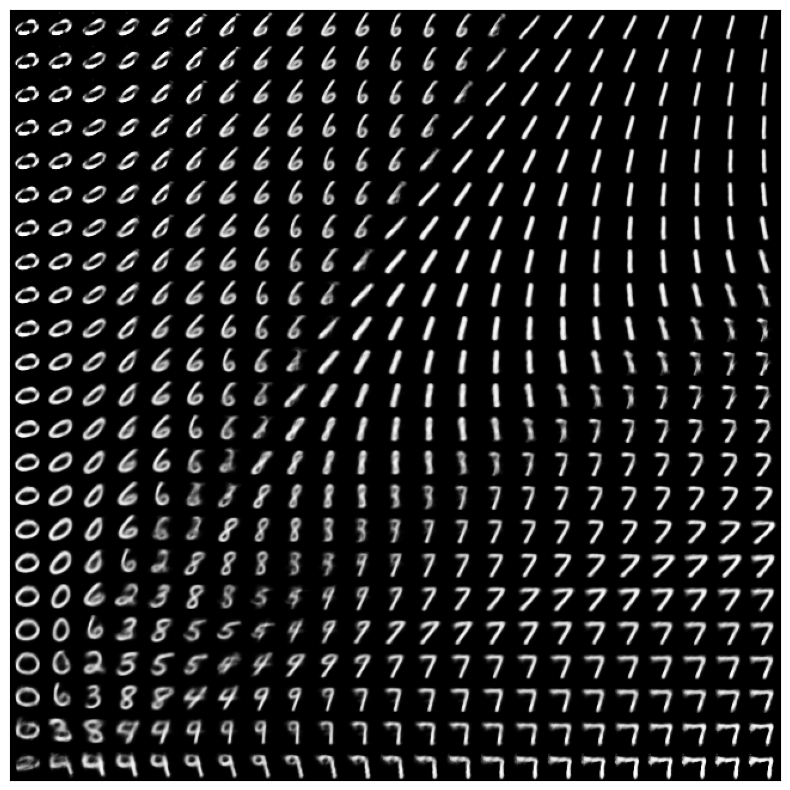

In [25]:
draw_decoder_grid(steps = 23,
                  limits = (0, 55, 0, 55),
                  filename = 'NB2-MLP-AE6-17-decoder-grid')

# Activity # 3
Explore the latent variables close to 0 (e.g., -1 to 1)

In [ ]:
# your code here

# Convolutional autoencoders

In [26]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, Dense, Input, MaxPooling2D, UpSampling2D
from keras.utils import np_utils
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
import h5py


In [27]:
# Data now has a different shape
random_seed = 42
np.random.seed(random_seed)

# load the MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
image_height = X_train.shape[1]
image_width = X_train.shape[2]
number_of_pixels = image_height * image_width

# cast the sample data to the current Keras floating-point type
X_train = keras_backend.cast_to_floatx(X_train)
X_test = keras_backend.cast_to_floatx(X_test)

# reshape to 2D grid, one line per image
X_train = X_train.reshape(X_train.shape[0], number_of_pixels)
X_test = X_test.reshape(X_test.shape[0], number_of_pixels)

# scale data to range [0, 1]
X_train /= 255.0
X_test /= 255.0

# reshape sample data to 4D tensor using channels_last convention
X_train = X_train.reshape(X_train.shape[0], image_height, image_width, 1)
X_test = X_test.reshape(X_test.shape[0], image_height, image_width, 1)

# replace label data with one-hot encoded versions
number_of_classes = 1 + max(np.append(y_train, y_test))
y_train = np_utils.to_categorical(y_train, number_of_classes)
y_test = np_utils.to_categorical(y_test, number_of_classes)

In [28]:
X_test.shape

(10000, 28, 28, 1)

In [29]:
# Convolutional autoencoder
CAE_encoder_input = Input(shape=(28, 28, 1))
CAE_encoder_conv_1 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')
CAE_encoder_pool_1 = MaxPooling2D((2,2), padding = 'same')
CAE_encoder_conv_2 = Conv2D(8, (3, 3), activation = 'relu', padding = 'same')
CAE_encoder_pool_2 = MaxPooling2D((2,2), padding = 'same')
CAE_encoder_output = Conv2D(3, (3, 3), activation = 'relu', padding = 'same')

CAE_decoder_up_1 = UpSampling2D((2,2))
CAE_decoder_conv_1 = Conv2D(16, (3, 3), activation = 'relu', padding = 'same')
CAE_decoder_up_2 = UpSampling2D((2,2))
CAE_decoder_output = Conv2D(1, (3, 3), activation = 'sigmoid', padding = 'same')

CAE_encoder_step_1 = CAE_encoder_conv_1(CAE_encoder_input)
CAE_encoder_step_2 = CAE_encoder_pool_1(CAE_encoder_step_1)
CAE_encoder_step_3 = CAE_encoder_conv_2(CAE_encoder_step_2)
CAE_encoder_step_4 = CAE_encoder_pool_2(CAE_encoder_step_3)
CAE_encoder_step_5 = CAE_encoder_output(CAE_encoder_step_4)

CAE_decoder_step_1 = CAE_decoder_up_1(CAE_encoder_step_5)
CAE_decoder_step_2 = CAE_decoder_conv_1(CAE_decoder_step_1)
CAE_decoder_step_3 = CAE_decoder_up_2(CAE_decoder_step_2)
CAE_decoder_step_4 = CAE_decoder_output(CAE_decoder_step_3)


Conv_AE = Model(CAE_encoder_input, CAE_decoder_step_4)
Conv_AE.compile(optimizer = 'adam', loss = 'binary_crossentropy')


Conv_AE_encoder_only_model = Model(CAE_encoder_input, CAE_encoder_step_5)

Conv_AE_decoder_only_input = Input(shape=(7, 7, 3))
Conv_AE_decoder_only_step_1 = CAE_decoder_up_1(Conv_AE_decoder_only_input)
Conv_AE_decoder_only_step_2 = CAE_decoder_conv_1(Conv_AE_decoder_only_step_1)
Conv_AE_decoder_only_step_3 = CAE_decoder_up_2(Conv_AE_decoder_only_step_2)
Conv_AE_decoder_only_step_4 = CAE_decoder_output(Conv_AE_decoder_only_step_3)

Conv_AE_decoder_only_model = Model(Conv_AE_decoder_only_input, Conv_AE_decoder_only_step_4)

In [30]:
Conv_AE.fit(X_train, X_train,
               epochs = 50, batch_size = 128, shuffle = True,
               verbose = 2,
               validation_data=(X_test, X_test))

Epoch 1/50
469/469 - 10s - loss: 0.1749 - val_loss: 0.0940 - 10s/epoch - 21ms/step
Epoch 2/50
469/469 - 2s - loss: 0.0907 - val_loss: 0.0867 - 2s/epoch - 5ms/step
Epoch 3/50
469/469 - 3s - loss: 0.0859 - val_loss: 0.0835 - 3s/epoch - 6ms/step
Epoch 4/50
469/469 - 2s - loss: 0.0834 - val_loss: 0.0819 - 2s/epoch - 5ms/step
Epoch 5/50
469/469 - 2s - loss: 0.0818 - val_loss: 0.0803 - 2s/epoch - 5ms/step
Epoch 6/50
469/469 - 2s - loss: 0.0808 - val_loss: 0.0795 - 2s/epoch - 5ms/step
Epoch 7/50
469/469 - 2s - loss: 0.0800 - val_loss: 0.0788 - 2s/epoch - 5ms/step
Epoch 8/50
469/469 - 3s - loss: 0.0793 - val_loss: 0.0782 - 3s/epoch - 6ms/step
Epoch 9/50
469/469 - 2s - loss: 0.0788 - val_loss: 0.0778 - 2s/epoch - 5ms/step
Epoch 10/50
469/469 - 2s - loss: 0.0783 - val_loss: 0.0774 - 2s/epoch - 5ms/step
Epoch 11/50
469/469 - 2s - loss: 0.0779 - val_loss: 0.0770 - 2s/epoch - 5ms/step
Epoch 12/50
469/469 - 2s - loss: 0.0776 - val_loss: 0.0766 - 2s/epoch - 4ms/step
Epoch 13/50
469/469 - 3s - loss: 0

In [31]:
def draw_predictions_set(predictions, filename = None):
    plt.figure(figsize = (8, 4))
    for i in range(5):
        plt.subplot(2, 5, i + 1)
        plt.imshow(X_test[i].reshape(28, 28), vmin = 0, vmax = 1, cmap = 'gray')
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        plt.subplot(2, 5, i + 6)
        plt.imshow(predictions[i].reshape(28, 28), vmin = 0, vmax = 1, cmap = 'gray')
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.tight_layout()
    plt.show()

313/313 [==============================] - 1s 3ms/step


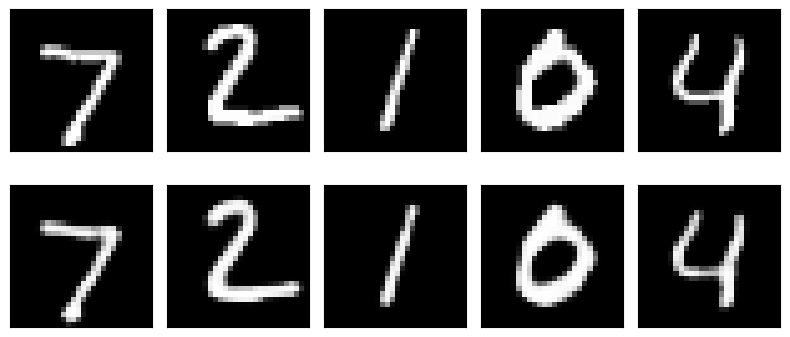

In [32]:
# it should be much higher quality than before
Conv_predictions = Conv_AE.predict(X_test)
draw_predictions_set(Conv_predictions, 'NB3-ConvAE-predictions')

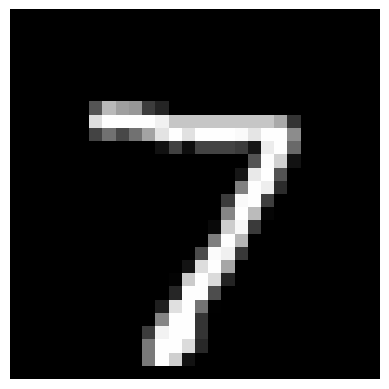

In [33]:
# denoising
plt.imshow(X_test[0][:,:,0], 'gray')
plt.axis('off');

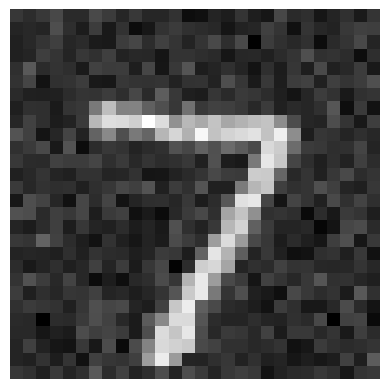

In [34]:
# add noise
noisy_input = X_test[0] + np.random.normal(loc = 0.0,
                                           scale = 0.1,
                                           size = X_test[0].shape)
plt.imshow(noisy_input[:,:,0], 'gray')
plt.axis('off');

In [35]:
# let's encode it
noisy_input.shape

(28, 28, 1)

In [36]:
# needs to add batch dimension
noisy_encoding = Conv_AE_encoder_only_model.predict(np.expand_dims(noisy_input, 0))

1/1 [==============================] - 0s 141ms/step


In [37]:
noisy_decoding = Conv_AE_decoder_only_model.predict(noisy_encoding)

1/1 [==============================] - 0s 101ms/step


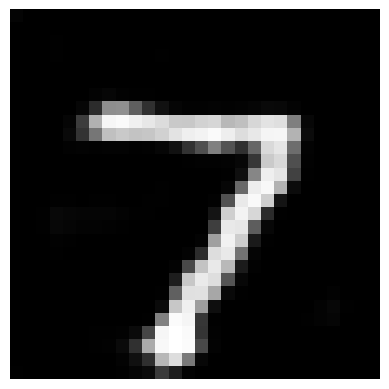

In [38]:
# remove batch and channel dimensions
plt.imshow(noisy_decoding[0, :, :, 0], 'gray')
plt.axis('off');

# Activity # 4

Add even more noise to the input (gaussian noise with scale 0.4). Can it reconstruct it properly?

In [ ]:
# your code here